In [1]:
from keras.datasets import fashion_mnist as data
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 14.1 MB/s 
     |████████████████████████████████| 144 kB 64.9 MB/s 
     |████████████████████████████████| 181 kB 49.8 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=eae70759879a982cafbe7cc8c56382524dd1a959480ea6a6f4cfb57f7153988e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def flatten_input(X_train, X_test):
  num_train = X_train.shape[0]
  num_test = X_test.shape[0]
  features = X_train.shape[1]*X_train.shape[2]  # 28x28 = 784
  X_train=X_train.reshape(num_train, features)
  X_test=X_test.reshape(num_test,features)


  X_train=np.transpose(X_train)
  X_test = np.transpose(X_test)

  X_train = X_train/255  # normalised data
  X_test = X_test/255

  return(X_train, X_test)

def OneHotEncoding(Y_train,num_train):
  Y= Y_train[:]
  Y = Y.reshape(num_train,1)

  Y_train=np.zeros([10,num_train])

  for i in range(num_train):
    index=Y[i,0]
    Y_train[index,i]=1
  return(Y_train, Y)



In [4]:

def shuffle_data(X_train, Y_train):
  m=X_train.shape[1]
  permutation = list(np.random.permutation(m))
  X_train = X_train[:, permutation]
  Y_train = Y_train[:, permutation]
  return(X_train,Y_train)





def get_mini_batches(X_train, Y_train,mini_batch_size):
    m=X_train.shape[1]  
    num_batches = m//mini_batch_size
    X_mini_batches = []
    Y_mini_batches = []

    X_train, Y_train = shuffle_data(X_train, Y_train)

    for i in range(num_batches):
      x=X_train[:,i*mini_batch_size:(i+1)*(mini_batch_size)]
      y=Y_train[:,i*mini_batch_size:(i+1)*(mini_batch_size)]
      X_mini_batches.append(x)
      Y_mini_batches.append(y)

    if m%mini_batch_size!=0:
      index = num_batches*mini_batch_size
      x=X_train[:,index:index+m%mini_batch_size]
      y=Y_train[:,index:index+m%mini_batch_size]
      X_mini_batches.append(x)
      Y_mini_batches.append(y)
    
    
    return(X_mini_batches, Y_mini_batches)     

In [5]:
# Activations and their gradients


def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    return A

def reluGradient(z):
    dZ = np.zeros(z.shape) 
    dZ[z > 0] = 1
    assert (dZ.shape == z.shape)
    return dZ

def sigmoid(z):
    a=1/(1+np.exp(-z))
    return(a)


def sigmoidGradient(z):
    a=sigmoid(z)
    return(a*(1-a))


def tanh(z):
  a=np.tanh(z)
  return(a)

def tanhGradient(z):
  a=tanh(z)
  return(1-a**2)

def softmax(z):
    num=np.exp(z)
    den=np.sum(np.exp(z),axis=0)
    a=num/den
    return(a)



In [17]:


def initialize_weights(layers, params, M, R, initialiser):
  # seed=3
  # np.random.seed(seed)
  for i in range(1,len(layers)):
      if(initialiser=="xavier"):
        params["W"+str(i)]=np.random.randn(layers[i],layers[i-1])*np.sqrt(2 / (layers[i]+layers[i-1]))
      elif(initialiser=="random"):
        params["W"+str(i)]=np.random.randn(layers[i],layers[i-1])*0.01

      params["b"+str(i)]=np.zeros([layers[i],1])
      M["W"+str(i)]=np.zeros([layers[i],layers[i-1]])
      M["b"+str(i)]=np.zeros([layers[i],1])
      R["W"+str(i)]=np.zeros([layers[i],layers[i-1]])
      R["b"+str(i)]=np.zeros([layers[i],1])
  return(params, M, R)


def feedforward(params,layers,X,activation):
    
    a=X
    n=len(layers)-1
    Z=[]
    A=[]
    A.append(X)
    Z.append(X)
    for i in range(1,len(layers)-1):
        W=params["W"+str(i)]
        b=params["b"+str(i)]
        z = np.dot(W,a)+b
        if(activation=="relu"):
          a = relu(z)
        elif(activation=="sigmoid"):
          a = sigmoid(z)
        elif(activation=="tanh"):
          a = tanh(z)
        A.append(a)
        Z.append(z)
    W=params["W"+str(n)]
    b=params["b"+str(n)]
    z = np.dot(W,a)+b
    a = softmax(z)
    Z.append(z)
    A.append(a)
    return(A,Z)



def backwardPropagate(params, layers, Z, A, learning_rate, Y, activation):
    m=Y.shape[1]
    l=len(layers)-1
    dz= A[l]-Y
    gradients={}
    while(l>=0):
        dw = np.dot(dz,np.transpose(A[l-1]))/m
        db = np.sum(dz,axis=1)/m 
        db=db.reshape(db.shape[0],1)
        gradients["dw"+str(l)]=dw
        gradients["db"+str(l)]=db
        if(l>=2):
            da= np.dot(np.transpose(params["W"+str(l)]), dz)
            if(activation=="relu"):
              dz = da*reluGradient(Z[l-1])
            elif(activation=="sigmoid"):
              dz = da*sigmoidGradient(Z[l-1])
            elif(activation=="tanh"):
              dz = da*tanhGradient(Z[l-1])
        l=l-1
    return(gradients)

        
def crossEntropyError(a,Y,params,layers,weight_decay):
    m=a.shape[1]
    error=-(np.sum(np.sum(Y*np.log(a),axis=1),axis=0))
    #error=-np.sum(Y*np.log(a)+(1-Y)*np.log(1-a))/m
    for i in range(1,len(layers)):
      regu_cost = (weight_decay/2)*np.sum(np.sum(np.square(params["W"+str(i)]),axis=1),axis=0)
    error+=regu_cost
    return(error)
     
def squaredError(a,Y,params,layers,weight_decay):
    m=a.shape[1]
    error=np.sum(np.square(a-Y),axis=1)
    for i in range(1,len(layers)):
      regu_cost = (weight_decay/2)*np.sum(np.sum(np.square(params["W"+str(i)]),axis=1),axis=0)
    error+=regu_cost
    return(error)

# m is number of examples



In [18]:
def updateWeightsSGD(m, params,gradients,layers, learning_rate, weight_decay):
    for i in range(1,len(layers)):
        params["W"+str(i)]-= learning_rate*gradients["dw"+str(i)]
        params["b"+str(i)]-= learning_rate*gradients["db"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params)


def updateWeightsMomentum(m, params, gradients, M, layers, learning_rate,weight_decay, beta):
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta*M["W"+str(i)]+(1-beta)*gradients["dw"+str(i)]
        M["b"+str(i)]=beta*M["b"+str(i)]+(1-beta)*gradients["db"+str(i)]
        params["W"+str(i)]-= learning_rate* M["W"+str(i)]
        params["b"+str(i)]-= learning_rate*M["b"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M)


def updateWeightsRMS(m, params, gradients,R, layers, learning_rate, weight_decay, beta ,eps):

    for i in range(1,len(layers)):
        R["W"+str(i)]=beta*R["W"+str(i)]+(1-beta)*np.power(gradients["dw"+str(i)],2)
        R["b"+str(i)]=beta*R["b"+str(i)]+(1-beta)*np.power(gradients["db"+str(i)],2)
        params["W"+str(i)]-= (learning_rate*gradients["dw"+str(i)])/(np.sqrt(R["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*gradients["db"+str(i)])/(np.sqrt(R["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,R)


def updateWeightsNesterov(m, params, lookahead_grads, M, layers, learning_rate, weight_decay, beta):
    
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta*M["W"+str(i)]+(1-beta)*lookahead_grads["dw"+str(i)]
        M["b"+str(i)]=beta*M["b"+str(i)]+(1-beta)*lookahead_grads["db"+str(i)]
        params["W"+str(i)]-= learning_rate* M["W"+str(i)]
        params["b"+str(i)]-= learning_rate*M["b"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M)

def updateWeightsNAdam(m, params, lookahead_grads, layers, M, R, learning_rate, weight_decay, gamma1, gamma2, eps, t):
    M_c={}
    R_c={}
    for i in range(1,len(layers)):
        M["W"+str(i)]=gamma1*M["W"+str(i)]+(1-gamma1)*lookahead_grads["dw"+str(i)]
        M["b"+str(i)]=gamma1*M["b"+str(i)]+(1-gamma1)*lookahead_grads["db"+str(i)]
        M_c["W"+str(i)]=M["W"+str(i)]/(1-np.power(gamma1,t))
        M_c["b"+str(i)]=M["b"+str(i)]/(1-np.power(gamma1,t))
        R["W"+str(i)]=gamma2*R["W"+str(i)]+(1-gamma2)*np.power(lookahead_grads["dw"+str(i)],2)
        R["b"+str(i)]=gamma2*R["b"+str(i)]+(1-gamma2)*np.power(lookahead_grads["db"+str(i)],2)
        R_c["W"+str(i)]=R["W"+str(i)]/(1-np.power(gamma2,t))
        R_c["b"+str(i)]=R["b"+str(i)]/(1-np.power(gamma2,t))
        params["W"+str(i)]-= (learning_rate*M_c["W"+str(i)])/(np.sqrt(R_c["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*M_c["b"+str(i)])/(np.sqrt(R_c["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
        
    return(params,M,R)

def updateWeightsAdam(m, params, gradients, layers, M, R, learning_rate, weight_decay, gamma1, gamma2, eps, t):
    M_c={}
    R_c={}
    for i in range(1,len(layers)):
        M["W"+str(i)]=gamma1*M["W"+str(i)]+(1-gamma1)*gradients["dw"+str(i)]
        M["b"+str(i)]=gamma1*M["b"+str(i)]+(1-gamma1)*gradients["db"+str(i)]
        M_c["W"+str(i)]=M["W"+str(i)]/(1-np.power(gamma1,t))
        M_c["b"+str(i)]=M["b"+str(i)]/(1-np.power(gamma1,t))
        R["W"+str(i)]=gamma2*R["W"+str(i)]+(1-gamma2)*np.power(gradients["dw"+str(i)],2)
        R["b"+str(i)]=gamma2*R["b"+str(i)]+(1-gamma2)*np.power(gradients["db"+str(i)],2)
        R_c["W"+str(i)]=R["W"+str(i)]/(1-np.power(gamma2,t))
        R_c["b"+str(i)]=R["b"+str(i)]/(1-np.power(gamma2,t))
        params["W"+str(i)]-= (learning_rate*M_c["W"+str(i)])/(np.sqrt(R_c["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*M_c["b"+str(i)])/(np.sqrt(R_c["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M,R)

In [19]:

def predict(params, layers, X_train, X_test, Y_train_orig, Y_test,activation):
  num_train = X_train.shape[1]
  num_test = X_test.shape[1]
  

  A,Z=feedforward(params, layers, X_train,activation)
  pred=A[-1]
  max_index = np.argmax(pred, axis=0)
  count=0
  for i in range(num_train):
      if(Y_train_orig[0,i]==max_index[i]):
          count+=1
  
  print("train accuracy: ",(count/num_train)*100)
  validationaccuracy = (count/num_train)*100

  A,Z=feedforward(params, layers, X_test,activation)
  pred=A[-1]
  max_index = np.argmax(pred, axis=0)
  count=0
  for i in range(num_test):
      if(Y_test[0,i]==max_index[i]):
          count+=1
  print("test accuracy: ",(count/num_test)*100)

  return((count/num_train)*100)
          
      
  



In [20]:
(X_train, Y_train), (X_test, Y_test) = data.load_data()
(X_train, X_test) = flatten_input(X_train,X_test)


num_train= X_train.shape[1]
num_test=X_test.shape[1]


(Y_train,Y_train_orig)= OneHotEncoding(Y_train,num_train)

Y_train_orig= Y_train_orig.reshape(1,num_train)
Y_test= Y_test.reshape(1,num_test)


print(X_train.shape,Y_train.shape, X_test.shape, Y_test.shape)

(784, 60000) (10, 60000) (784, 10000) (1, 10000)


In [21]:

sweep_config = {
  "name": "Random Sweep",
  "method": "random",
  "metric":{
  "name": "validationaccuracy",
  "goal": "maximize"
  },
  "parameters": {
        "epochs": {
            #"values": [5, 10]
            "values": [10]
        },

        "initialiser": {
            #"values": ["random", "xavier"]
            "values": ["random"]
        },

        "hidden_layers": {
            #"values": [3,4,5]
            "values": [3]
        },
        
        
        "size_hidden_layer": {
             #"values": [32, 64, 128]
             "values": [64]

        },
        
        "activation": {
            #"values": [ 'sigmoid', 'tanh','relu']
            "values": [ 'relu']
        },
        
        "learning_rate": {
             #"values": [0.001, 0.0001]
            "values": [0.001]
        },
        
        
        "weight_decay": {
            #"values": [0, 0.0005,0.5]
            "values": [0]
        },
        
        "optimiser": {
             #"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
             "values": [ "adam"]
        },
                    
        "mini_batch_size": {
             "values": [32]
             #"values": [32,64]
        }
        
        
    }
}

sweep_id = wandb.sweep(sweep_config,project='Assignment 1', entity='go4rav')


Create sweep with ID: 89m0ezxg
Sweep URL: https://wandb.ai/go4rav/Assignment%201/sweeps/89m0ezxg


In [22]:
def train_model():
    wandb.init(project="assignment_1_",entity='go4rav')
    CONFIG=wandb.config
    print("Testing",CONFIG)
    hidden_layers=CONFIG.hidden_layers
    size_hidden_layer=CONFIG.size_hidden_layer
    learning_rate=CONFIG.learning_rate
    weight_decay=CONFIG.weight_decay
    optimiser=CONFIG.optimiser
    activation=CONFIG.activation
    epochs=CONFIG.epochs
    mini_batch_size=CONFIG.mini_batch_size
    initialiser=CONFIG.initialiser
    
    layers=[X_train.shape[0]]
    for i in range(hidden_layers):
      layers.append(size_hidden_layer)
    layers.append(Y_train.shape[0])
    params={}
    M={}
    R={}
    lookahead_params={}
    errors=[]
    
    params, M, R = initialize_weights(layers, params, M, R,initialiser)
    (X_mini_batches, Y_mini_batches) = get_mini_batches(X_train, Y_train,mini_batch_size)
    errors=[]
    epoch=1
    gamma1=0.9
    gamma2=0.999
    eps=1e-8
    seed=10
    beta=0.9
    m=X_train.shape[1]
    
    t=0

    while(epoch<=epochs):
        error=0
        for i in range(len(X_mini_batches)):
          X_train_mini=X_mini_batches[i]
          Y_train_mini=Y_mini_batches[i]
          A,Z=feedforward(params, layers, X_train_mini,activation)
          error+= crossEntropyError(A[-1], Y_train_mini,params,layers,weight_decay)
          #error=squaredError(A[-1],Y_train)
          if(optimiser=="nadam" or optimiser=="nesterov"):
              for i in range(1,len(layers)):
                lookahead_params["W"+str(i)]=params["W"+str(i)]-M["W"+str(i)]
                lookahead_params["b"+str(i)]=params["b"+str(i)]-M["b"+str(i)]
              lookahead_grads=backwardPropagate(lookahead_params, layers,Z, A, learning_rate, Y_train_mini,activation)
              if(optimiser=="nesterov"):
                params, M = updateWeightsNesterov(num_train, params, lookahead_grads, M, layers, learning_rate, weight_decay, beta)
              elif(optimiser=="nadam"):
                t=t+1
                params,M,R = updateWeightsNAdam(num_train, params, lookahead_grads, layers, M, R, learning_rate, weight_decay, gamma1,gamma2,eps,t)

          else:
              gradients=backwardPropagate(params, layers,Z, A, learning_rate, Y_train_mini, activation)
              if(optimiser=="sgd"):
                params = updateWeightsSGD(num_train, params,gradients,layers, learning_rate, weight_decay)
              elif(optimiser=="momentum"):
                params,M = updateWeightsMomentum(num_train, params, gradients, M, layers, learning_rate,weight_decay, beta)
              elif(optimiser=="rmsprop"):
                params, R = updateWeightsRMS(num_train, params, gradients, R, layers, learning_rate, weight_decay, beta ,eps)
              elif(optimiser=="adam"):
                t=t+1
                params, M, R = updateWeightsAdam(num_train,params, gradients, layers, M, R, learning_rate, weight_decay, gamma1, gamma2, eps, t)
        error=error/m
        if(epoch<=10):
          errors.append(error)
          print(error,epoch)

        elif(epoch%10==0):
          errors.append(error)
          print(error,epoch)
        epoch+=1
      
    #A,Z=feedforward(params, layers, X_train)
    #print(A[-1])

    plt.plot(errors)
    plt.xlabel("EPOCHS")
    plt.ylabel("Loss value")

    validationaccuracy=predict(params, layers, X_train, X_test, Y_train_orig, Y_test,activation)

wandb: Agent Starting Run: 1v1gkfct with config:
wandb: 	activation: relu
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	initialiser: random
wandb: 	learning_rate: 0.001
wandb: 	mini_batch_size: 32
wandb: 	optimiser: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Testing {'activation': 'relu', 'epochs': 10, 'hidden_layers': 3, 'initialiser': 'random', 'learning_rate': 0.001, 'mini_batch_size': 32, 'optimiser': 'adam', 'size_hidden_layer': 64, 'weight_decay': 0}
0.9488768299393197 1
0.6156172437194671 2
0.5035053944601432 3
0.4458615618776235 4
0.40706628142651746 5
0.378090605897087 6
0.35626426473647965 7
0.3373357324970534 8
0.32197322773457593 9
0.3106407224828778 10
train accuracy:  89.29
test accuracy:  86.53


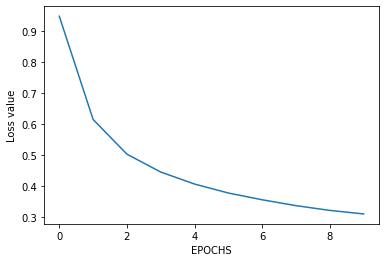

In [23]:
#train_model(X_train, Y_train,X_test, Y_test, Y_train_orig)
wandb.agent(sweep_id, train_model,count = 1)